# Exploring the single member (mem001) control and historical run

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
hist_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/mem001/'
ctrl_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-ctrl-19601101/mem001/'

In [3]:
hist_files = sorted(glob.glob(f'{hist_path}ocean_scalar_*.nc'))[:-1] # Last year still writing
hist_ocean_scalar = xr.open_mfdataset(hist_files)

ctrl_files = sorted(glob.glob(f'{ctrl_path}ocean_scalar_*.nc'))[:-1] # Last year still writing
ctrl_ocean_scalar = xr.open_mfdataset(ctrl_files)

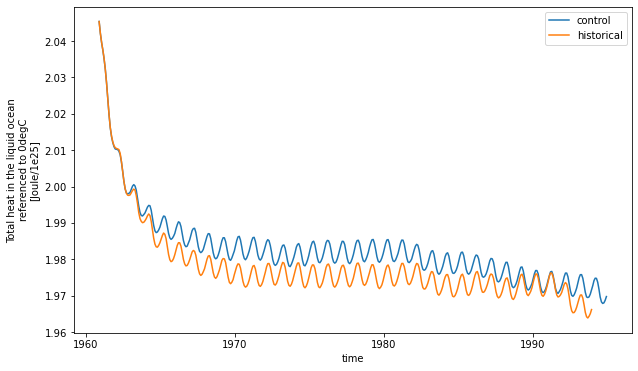

In [4]:
fig = plt.figure(figsize=(10,6))
ctrl_ocean_scalar['temp_total'].plot(label='control')
hist_ocean_scalar['temp_total'].plot(label='historical')
plt.legend()
plt.title('');

In [25]:
hist_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/hist/'
ctrl_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/progress_check/ctrl/'

In [26]:
hist_files = sorted(glob.glob(f'{hist_path}atmos_month_*.nc'))
hist_atmos_month = xr.open_mfdataset(hist_files)

ctrl_files = sorted(glob.glob(f'{ctrl_path}atmos_month_*.nc'))
ctrl_atmos_month = xr.open_mfdataset(ctrl_files)

area = ctrl_atmos_month['area'].isel(time=0).drop('time')

In [27]:
ctrl_gbl = ctrl_atmos_month['t_surf'].weighted(area).mean(['lat','lon'])
hist_gbl = hist_atmos_month['t_surf'].weighted(area).mean(['lat','lon'])

ctrl_gbl_anom = ctrl_gbl.groupby('time.month').apply(lambda x: x - x.mean('time'))
hist_gbl_anom = hist_gbl.groupby('time.month').apply(lambda x: x - x.mean('time'))

<Figure size 720x432 with 0 Axes>

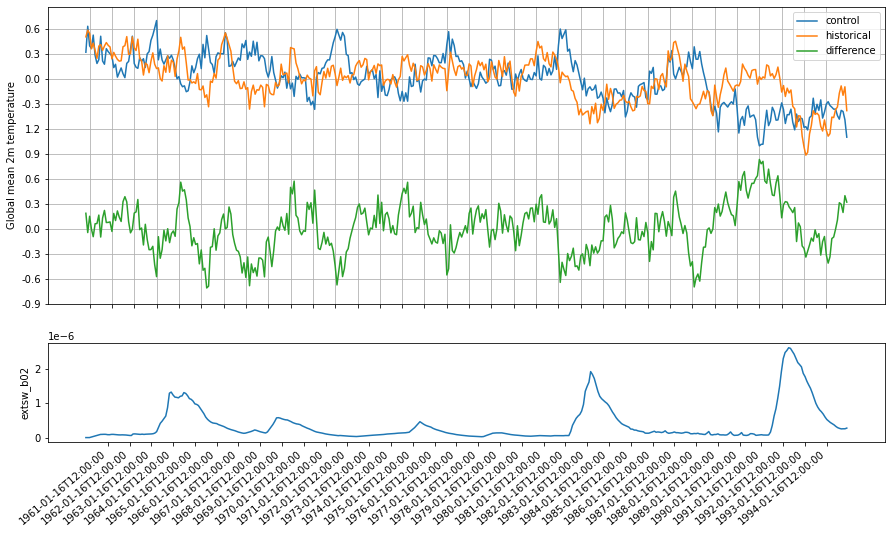

In [30]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,6))

fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(15,8))

shift = 1.8
ax0.plot([np.datetime64(t.strftime()) for t in ctrl_gbl_anom.time.values], 
         ctrl_gbl_anom, label='control')
ax0.plot([np.datetime64(t.strftime()) for t in hist_gbl_anom.time.values], 
         hist_gbl_anom, label='historical')
ax0.plot([np.datetime64(t.strftime()) for t in hist_gbl_anom.time.values], 
         hist_gbl_anom-ctrl_gbl_anom-shift, label='difference')
ax0.legend()
ax0.set_ylabel('Global mean 2m temperature');
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in ctrl_gbl_anom.time.values[2::12]]
ax0.set_xticks(xticks)
ax0.set_xticklabels([])

ylims = ax0.get_ylim()
lower = round(ylims[0], 1)
mid = round((shift+round(ylims[0], 1))/2,2)
upper = round(ylims[1], 1)
step = 0.3
lowerticks = np.concatenate(
    (np.flip(np.arange(-shift, lower, -step)),
     np.arange(-shift, mid, step)[1:]))
upperticks = np.concatenate(
    (np.flip(np.arange(0, mid, -step)),
     np.arange(0, upper, step)[1:]))
ticks = np.concatenate(
    (lowerticks,
     upperticks))
ticklabels = np.round(
    np.concatenate(
    (lowerticks+shift,
     upperticks)), decimals=2)
ax0.set_yticks(ticks)
ax0.set_yticklabels(ticklabels);
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

forcing_path = '/scratch/ux06/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101/mem001/'
f = xr.open_dataset(f'{forcing_path}INPUT/extsw_data.nc')

period = slice(str(ctrl_gbl_anom.time[0].dt.year.values), 
               str(ctrl_gbl_anom.time[-1].dt.year.values))
lev = 60

lat_mean = f['extsw_b02'].sel(time=period).mean('lat')
ax1.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
        lat_mean.sel(pfull=lev, method='nearest'))
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=40, ha='right');
ax1.set_ylabel('extsw_b02');